In [1]:
# Add the parent directory to path
import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env import Env, Log
from epidemic_env.dynamics import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

"""Policy imports"""
from typing import Callable
from utils.utils import simulate_policy

%matplotlib inline

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np

import json

In [4]:
q4a_folder = Path("../results/q4a")

visualization_folder = Path("../results/visualization")
visualization_folder.mkdir(exist_ok=True, parents=True)

In [5]:
class DQNModel(nn.Module):
    def __init__(self, obs_dim: int, actions_dim: int, activation: str = "relu"):
        super().__init__()
        if activation == "relu":
            self.activation = nn.ReLU
        elif activation == "tanh":
            self.activation = nn.Tanh
        else:
            raise ValueError("Activation must be either relu or tanh")

        self.net = nn.Sequential(
            # nn.LayerNorm(obs_dim),
            nn.Linear(obs_dim, 64),
            self.activation(),
            nn.Linear(64, 32),
            self.activation(),
            nn.Linear(32, 16),
            self.activation(),
            nn.Linear(16, actions_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [6]:
def get_models(num_obs: int, num_output: int, run_folder: Path) -> dict[int, torch.nn.Module]:
    files = run_folder.glob("*.pt")
    run_ids_paths = [(int(str(x).split("_")[2]), x) for x in files]

    models = {}
            
    for run_id, weights_path in run_ids_paths:
        model = DQNModel(num_obs, num_output)
        model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
        model.eval()
        models[run_id] = model
    
    return models

## Q4a Plots

In [16]:
num_features_per_city = 2
num_actions = 5
num_observation_features = 7 * num_features_per_city * 9  + 4
def observation_to_tensor(
    obs: Observation,
    dyn: ModelDynamics,
    curr_action: dict,
    features_per_city: int = 7 * num_features_per_city,
) -> torch.Tensor:
    """Convers the observation object to a torch Tensor
    The tensor is defined as: for each city, population (1), infected (7), dead (7)
    """
    num_cities = len(dyn.cities)
    output = torch.zeros(num_cities * features_per_city + 4)
    for i, city in enumerate(dyn.cities):
        output[i * features_per_city : i * features_per_city + 7] = (
            torch.tensor(obs.city[city].infected) / obs.pop[city]
        ) ** (1 / 4)
        output[i * features_per_city + 7 : i * features_per_city + 14] = (
            torch.tensor(obs.city[city].dead) / obs.pop[city]
        ) ** (1 / 4)
        
    
    output[-4] = int(curr_action["confinement"])
    output[-3] = int(curr_action["isolation"])
    output[-2] = int(curr_action["hospital"])
    output[-1] = int(curr_action["vaccinate"])
    
    return output


"""Loading the environment"""
dyn = ModelDynamics("../config/switzerland.yaml") 

env = Env(
    dyn,  # We pass the dynamical model to the environment
    action_space=spaces.Discrete(
        num_actions
    ),  # Here one could pass an openai gym action space that can then be sampled
    observation_space=spaces.Box(
        low=0, high=np.inf, shape=(num_observation_features,), dtype=float
    ),  # Here one could pass an openai gym obs space that can then be sampled
)

def action_value_to_actions(action_value: int, curr_action: dict) -> list[int]:
    if action_value == 0:
        return []
    str_action = action_value_dict[action_value - 1]

    return [str_action]



action_value_dict = {0: "confinement", 1: "isolation", 2: "hospital", 3: "vaccinate"}

from copy import deepcopy

def create_action(
    action: int,
    curr_action: dict,
    action_value_to_actions: Callable = action_value_to_actions,
    action_value_dict: dict = action_value_dict,
) -> dict[str, bool]:
    """Creates a policy from the encoded action value"""
    created_actions = action_value_to_actions(action, curr_action)

    temp_act = deepcopy(curr_action)

    # print(f"returned action = {created_actions}")

    for act in created_actions:
        # print(act)
        temp_act[act] = not curr_action[act]

    # print(temp_act)
    return temp_act

def select_action(output: torch.Tensor, epsilon: float) -> int:
    """Selects an action based on the output of the DQN."""
    if np.random.rand() < epsilon:
        return np.random.randint(0, len(output))
    else:
        # print(f' \n inside select action output = {output} \n')
        # print(f' \n inside select action argmax = {output.to("cpu").argmax().item()}')
        return output.to("cpu").argmax().item()



tst_actions = {
    "confinement": False,
    "isolation": False,
    "hospital": False,
    "vaccinate": False,
}

print(action_value_to_actions(0, tst_actions))

print(action_value_to_actions(1, tst_actions))

print(action_value_to_actions(3, tst_actions))

tst_actions["confinement"] = True

print(action_value_to_actions(1, tst_actions))

tst_actions["hospital"] = True

print(action_value_to_actions(3, tst_actions))


[]
['confinement']
['hospital']
['confinement']
['hospital']


In [17]:
q4a_models = get_models(num_observation_features, num_actions, q4a_folder)
q4a_model = q4a_models[1]


In [36]:
def exec_model_policy(env: Env, dyn: ModelDynamics, policy_net: torch.nn.Module, device: str, n_weeks=30, simulation_seed=0, ):
    log = []
    curr_rewards = []
    taken_actions = []

    curr_action = {
        "confinement": False,
        "isolation": False,
        "hospital": False,
        "vaccinate": False,
    }

    obs, info = env.reset(simulation_seed)
    obs_tensor = observation_to_tensor(obs, dyn, curr_action).to(device)
    
    done = False
    while not done:
        policy_output = policy_net(obs_tensor)
        action = select_action(policy_output, 0)
        curr_action = create_action(action, curr_action)
        action_tuple = tuple([action for action, value in curr_action.items() if value])
        taken_actions.append(action_tuple)
        
        obs, reward, done, info = env.step(curr_action)
        obs_tensor = observation_to_tensor(obs, dyn, curr_action).to(device)
        curr_rewards.append(reward.item())
        log.append(info) 
        
    """ Parse the logs """
    tot = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
    cit = {
        c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters}
        for c in dyn.cities
    }
    act = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    return tot, cit, act, taken_actions, curr_rewards


In [91]:
def simulate_policy(env: Env, dyn: ModelDynamics, policy_net: torch.nn.Module, device: str, policy_function, n=5, seeds=[0]):
    # For each episode save the total days confined and total dead
    tot_days_confined = []
    tot_days_isolated = []
    tot_days_vaccinated = []
    tot_days_hospitalized = []
    tot_dead = []
    cum_rewards = []
    for i in range(n):
        tot, _, _, pol, r = policy_function(env=env, dyn=dyn, policy_net=policy_net, device=device, n_weeks=30, simulation_seed=seeds[i])
        cum_rewards.append(torch.sum(torch.tensor(r)))
        tot_dead.append(tot['dead'][-1])
        weeks_confined = len([x for x in pol if "confinement" in x])
        weeks_isolated = len([x for x in pol if "isolation" in x])
        weeks_vaccinated = len([x for x in pol if "vaccinate" in x])
        weeks_hospitalized = len([x for x in pol if "hospital" in x])
        
        tot_days_confined.append(7 * weeks_confined)
        tot_days_isolated.append(7 * weeks_isolated)
        tot_days_vaccinated.append(7 * weeks_vaccinated)
        tot_days_hospitalized.append(7 * weeks_hospitalized)
    
    tot_days = {"confinement": tot_days_confined, "isolation": tot_days_isolated, "vaccinate": tot_days_vaccinated, "hospital": tot_days_hospitalized}
        
    return tot_days, tot_dead, cum_rewards

In [92]:
tot_days, total_dead, cumulative_rewards = simulate_policy(env=env, dyn=dyn, policy_net=q4a_model, device="cpu", policy_function = exec_model_policy, n=50, seeds=np.arange(50)
)

In [94]:
print(tot_days.keys())

dict_keys(['confinement', 'isolation', 'vaccinate', 'hospital'])


In [95]:
# Print the mean and std
for key, total_days_action in tot_days.items():
    print(f"Mean total days {key}: {np.mean(total_days_action)}")
    print(f"Std total days {key}: {np.std(total_days_action)}")
print(f"Mean total dead: {np.mean(total_dead)}")
print(f"Std total dead: {np.std(total_dead)}")
print(f"Mean cumulative rewards: {np.mean(cumulative_rewards)}")
print(f"Std cumulative rewards: {np.std(cumulative_rewards)}")


Mean total days confinement: 157.5
Std total days confinement: 9.82496819333274
Mean total days isolation: 0.0
Std total days isolation: 0.0
Mean total days vaccinate: 0.0
Std total days vaccinate: 0.0
Mean total days hospital: 36.12
Std total days hospital: 65.47690890688105
Mean total dead: 2849.64
Std total dead: 1992.707261591627
Mean cumulative rewards: 41.82419967651367
Std cumulative rewards: 13.582307815551758


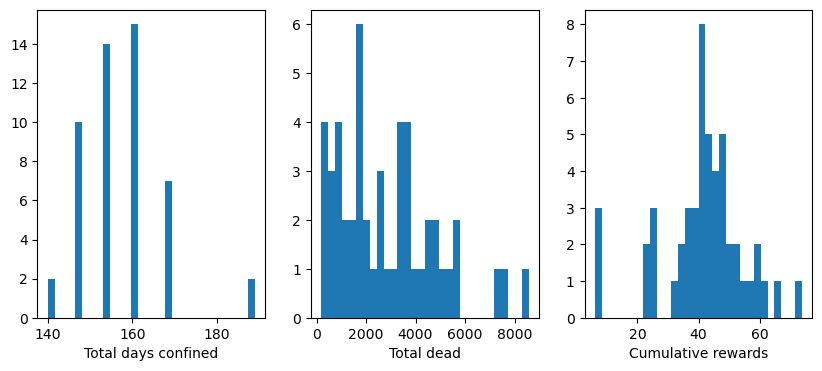

In [97]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

ax[0].hist(tot_days["confinement"], bins=30, label="total_confined")
ax[0].set_xlabel("Total days confined")

ax[1].hist(total_dead, bins=30, label="total_dead")
ax[1].set_xlabel("Total dead")

ax[2].hist(cumulative_rewards, bins=30, label="cumulative_rewards")
ax[2].set_xlabel("Cumulative rewards")

plt.savefig(visualization_folder / "4-1_histograms.png")

In [102]:
seed = 101
total, cities, actions, policy, _ = exec_model_policy(env=env, dyn=dyn, policy_net=q4a_model, device="cpu", n_weeks=30, simulation_seed=seed)

In [106]:
unique_actions = set(policy)
num_unique_actions = len(unique_actions)
# Assign a color to each action
action_to_color_id = {action: i for i, action in enumerate(unique_actions)}
action_to_color = {action: sns.color_palette()[i] for i, action in enumerate(unique_actions)}


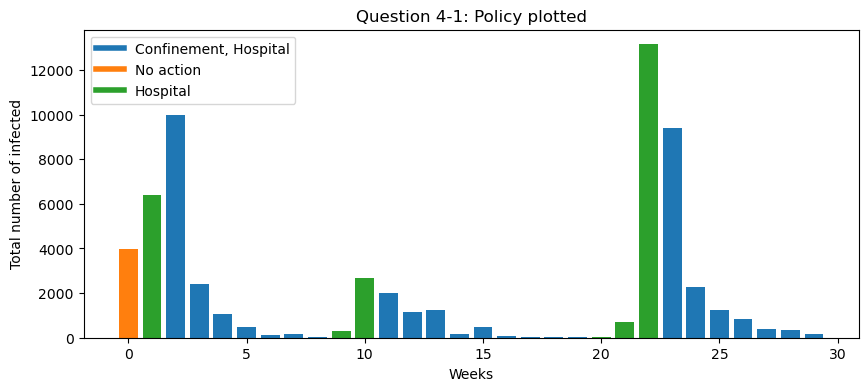

In [107]:
from matplotlib.lines import Line2D

def action_tuple_to_label(action_tuple: tuple[str, ...]) -> str:
    """Converts an action tuple to a label"""
    if len(action_tuple) == 0:
        return "No action"
    else:
        out = ""
        for t in action_tuple:
            out = out + t.capitalize() + ", "
        return out[:-2]

action_line_pair = [
    (action, Line2D([0], [0], color=color, lw=4)) for
    action, color in action_to_color.items()
]

actions_tuples= [x[0] for x in action_line_pair]

action_legend = [action_tuple_to_label(x) for x in actions_tuples]

lines_legend = [x[1] for x in action_line_pair]

np.unique
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

weeks = np.arange(len(policy))

colors = []

for i in range(len(policy)):
    colors.append(action_to_color[policy[i]])
    

total_tmp = {"infected": total["infected"]}
[ax.bar(weeks, y, color=colors) for y in total_tmp.values()]

# ax.axhline(y=INFECTED_THRESHOLD, color="gray", linestyle="--")
ax.legend(lines_legend, action_legend)
ax.set_title("Question 4-1: Policy plotted")
ax.set_ylabel("Total number of infected")
ax.set_xlabel("Weeks")
fig.savefig(visualization_folder / "4-1_policy.png")
